In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load Enhanced Data
data = pd.read_csv('/content/synthetic_sales_data (1).csv', parse_dates=['date'])
data.set_index('date', inplace=True)

# Feature Engineering
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Normalize numerical features
scaler = MinMaxScaler()
numerical_features = ['sales', 'economic_index', 'temperature']
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Prepare the LSTM input data
lookback = 30
def prepare_data(df, lookback):
    X, y = [], []
    for i in range(lookback, len(df)):
        X.append(df[i-lookback:i].values)
        y.append(df['sales'].values[i])
    return np.array(X), np.array(y)

# Select features for LSTM input
features = ['sales', 'day_of_week', 'month', 'promotion', 'economic_index', 'temperature']
X, y = prepare_data(data[features], lookback)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=10)

# Forecast function to predict using latest available data
def forecast_demand(recent_data):
    recent_data_scaled = recent_data.copy()
    recent_data_scaled[numerical_features] = scaler.transform(recent_data_scaled[numerical_features])

    # Reshape for prediction, adding a dimension for the single sample
    prediction = model.predict(recent_data_scaled.values.reshape(1, recent_data_scaled.shape[0], recent_data_scaled.shape[1]))

    # Create predict_transformed with the correct shape for inverse_transform
    predict_transformed = np.zeros((1, len(numerical_features)))  # Initialize with zeros and correct shape
    predict_transformed[0, 0] = prediction[0, 0]  # Assign the prediction to the 'sales' column

    # Inverse transform to get the actual sales value
    # Reshape predict_transformed to have the correct shape (1, 3) before inverse_transform
    return scaler.inverse_transform(predict_transformed)[0, 0] # Extract the sales value


# Placeholder functions - Replace with your actual EOQ and reorder point calculations
def eoq(demand):
    # Replace with your EOQ calculation logic
    return demand * 2  # Example: Doubling the demand as EOQ

def calculate_reorder_point(demand, lead_time, safety_stock):
    # Replace with your reorder point calculation logic
    return demand + lead_time + safety_stock # Example calculation

# Inventory prediction function
def predict_inventory():
    recent_data = data[features].tail(lookback)
    forecasted_demand = forecast_demand(recent_data)
    print(f"Forecasted Demand: {forecasted_demand:.2f}")

    optimal_order_quantity = eoq(forecasted_demand)
    reorder_point = calculate_reorder_point(forecasted_demand, lead_time=7, safety_stock=forecasted_demand * 0.2)

    print(f"Optimal Order Quantity (EOQ): {optimal_order_quantity:.2f}")
    print(f"Reorder Point: {reorder_point:.2f}")

# Run the inventory prediction
predict_inventory()

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4359/4359 ━━━━━━━━━━━━━━━━━━━━ 66s 14ms/step - loss: 0.0268
Epoch 2/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 82s 15ms/step - loss: 0.0119
Epoch 3/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 63s 14ms/step - loss: 0.0115
Epoch 4/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 79s 14ms/step - loss: 0.0107
Epoch 5/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 85s 15ms/step - loss: 0.0102
Epoch 6/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 84s 15ms/step - loss: 0.0106
Epoch 7/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 80s 14ms/step - loss: 0.0108
Epoch 8/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 60s 14ms/step - loss: 0.0107
Epoch 9/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 64s 15ms/step - loss: 0.0105
Epoch 10/10
4359/4359 ━━━━━━━━━━━━━━━━━━━━ 62s 14ms/step - loss: 0.0102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
Forecasted Demand: 76.74
Optimal Order Quantity (EOQ): 153.47
Reorder Point: 99.08


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Evaluate the model on test data
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Function to evaluate accuracy (Optional - For classification-style thresholds)
def evaluate_accuracy(y_true, y_pred, threshold=0.1):
    correct_predictions = np.abs((y_true - y_pred) / y_true) < threshold
    accuracy = np.mean(correct_predictions) * 100
    return accuracy

# Accuracy for a given threshold (e.g., 10% error tolerance)
accuracy = evaluate_accuracy(y_test, y_pred)
print(f"Accuracy within ±10% threshold: {accuracy:.2f}%")


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Squared Error (MSE): 0.01
Root Mean Squared Error (RMSE): 0.10
Mean Absolute Error (MAE): 0.08
Accuracy within ±10% threshold: 17.75%


<ipython-input-23-3e3ebe27a461>:18: RuntimeWarning: divide by zero encountered in divide
  correct_predictions = np.abs((y_true - y_pred) / y_true) < threshold


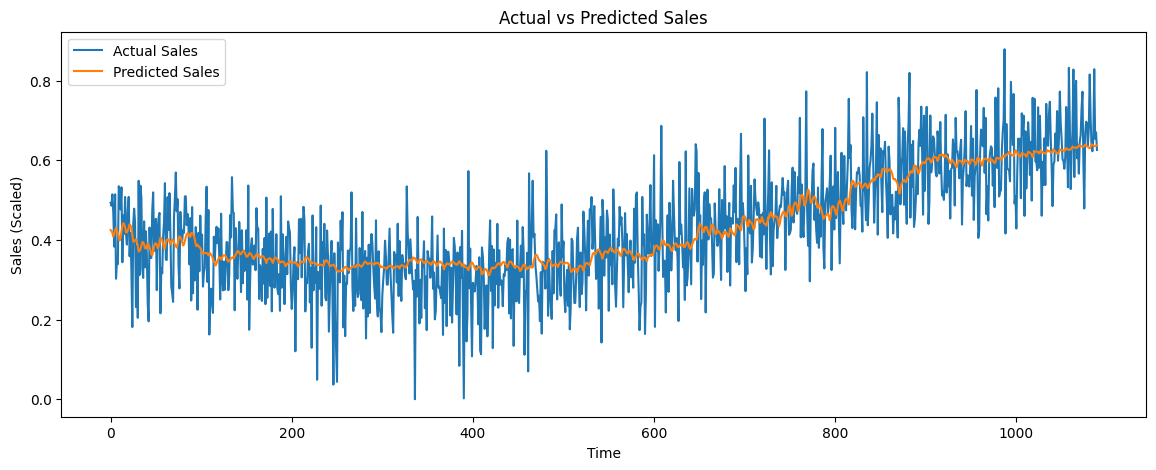

In [ ]:
import matplotlib.pyplot as plt# Optional: Plot actual vs predicted sales
plt.figure(figsize=(14,5))
plt.plot(y_test, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Time')
plt.ylabel('Sales (Scaled)')
plt.legend()
plt.show()

In [ ]:
# Save the model
model.save('inventory_lstm_model.h5')

# Later... Load the model
from tensorflow.keras.models import load_model

loaded_model = load_model('inventory_lstm_model.h5')


In [ ]:
def forecast_future(model, recent_data, scaler, numerical_features, features, forecast_steps=7, lookback=30):
    predictions = []
    current_data = recent_data.copy()

    for _ in range(forecast_steps):
        # Prepare input
        input_data = current_data[features].tail(lookback).copy()
        input_data[numerical_features] = scaler.transform(input_data[numerical_features])
        input_reshaped = input_data.values.reshape(1, lookback, len(features))

        # Predict
        pred_scaled = model.predict(input_reshaped)[0, 0]
        pred_original = scaler.inverse_transform([[pred_scaled] + [0] * (len(numerical_features) - 1)])[0, 0]
        predictions.append(pred_original)

        # Append the prediction to current_data for next prediction
        # Use the same feature values for simplicity
        new_row = current_data.iloc[-1].copy()
        new_row['sales'] = pred_scaled
        current_data = pd.concat([current_data, new_row.to_frame().T])

    return predictions

# Load Scaler
scaler = joblib.load('scaler.save')

# Forecast for Next 7 Days
recent_data = data.tail(lookback)
future_sales = forecast_future(model, recent_data, scaler, numerical_features, features, forecast_steps=7)

print("Forecasted Sales for Next 7 Days:", future_sales)

# Save Results to CSV
pd.DataFrame({'Forecasted Sales': future_sales}).to_csv('forecasted_sales.csv', index=False)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Forecasted Sales for Next 7 Days: [370.2047075331211, 366.99456200003624, 364.2045107483864, 361.8065756559372, 359.88339960575104, 358.3062084019184, 357.0264446735382]
